## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from tomo_encoders import Patches
from tomo_encoders import DataFile
import tensorflow as tf
sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter')
import time
from sparse_segmenter import SparseSegmenter
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes

In [2]:
GPU_mem_limit = 42.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])
  except RuntimeError as e:
    print(e)        

In [3]:
data_path = '/data02/MyArchive/AM_part_Xuan' #ensure this path matches where your data is located.

test_binning = None
# load vols here and quick look
dict_scrops = {'mli_L206_HT_650_L3' : (slice(100,-100, test_binning), \
                                    slice(None,None, test_binning), \
                                    slice(None,None, test_binning)), \
            'AM316_L205_fs_tomo_L5' : (slice(50,-50, test_binning), \
                                       slice(None,None, test_binning), \
                                       slice(None,None, test_binning))}

In [4]:
# create datasets input for train method
datasets = {}
for filename, s_crops in dict_scrops.items():
    ct_fpath = os.path.join(data_path, 'data', \
                            filename + '_rec_1x1_uint16.hdf5')
    seg_fpath = os.path.join(data_path, 'seg_data', \
                             filename, filename + '_GT.hdf5')
    
    datasets.update({filename : {'fpath_X' : ct_fpath, \
                                 'fpath_Y' : seg_fpath, \
                                 'data_tag_X' : 'data', \
                                 'data_tag_Y' : 'SEG', \
                                 's_crops' : s_crops}})

In [5]:
# syx = slice(600,-600,None)
# # view_midplanes(X[:,syx,syx])
# X = X[:,syx,syx]
# Y = Y[:,syx,syx]

## Train U-net for segmentation  

In [6]:
# Feature Extraction stuff
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/AM_part_segmenter'
descriptor_tag = 'test_noblanks_pt2cutoff'

model_size = (64,64,64)
model_params = {"n_filters" : [32, 64],\
                "n_blocks" : 2,\
                "activation" : 'lrelu',\
                "batch_norm" : True,\
                "isconcat" : [True, True],\
                "pool_size" : [2,4],\
                "stdinput" : True}

training_params = {"sampling_method" : "random", \
                   "batch_size" : 24, \
                   "n_epochs" : 30,\
                   "random_rotate" : True, \
                   "add_noise" : 0.05, \
                   "max_stride" : 8, \
                   "cutoff" : 0.2}
fe = SparseSegmenter(model_initialization = 'define-new', \
                         model_size = model_size, \
                         descriptor_tag = descriptor_tag, \
                         **model_params)

############# ii = 1
############# ii = 0


In [7]:
# fe.models["segmenter"].summary()

In [8]:
# for ii in range(len(fe.models['segmenter'].layers)):
#     lshape = str(fe.models['segmenter'].layers[ii].output_shape)
#     lname = str(fe.models['segmenter'].layers[ii].name)
#     print(lshape + "    ::    "  + lname) 

In [9]:
Xs, Ys = fe.load_datasets(datasets)

loading data...
done
Shape X (902, 4200, 4200), shape Y (902, 4200, 4200)
loading data...
done
Shape X (800, 5200, 5200), shape Y (800, 5200, 5200)


In [10]:
fe.train(Xs, Ys, training_params["batch_size"], \
         training_params["sampling_method"], \
         training_params["n_epochs"], \
         max_stride = training_params["max_stride"], \
         random_rotate = training_params["random_rotate"], \
         add_noise = training_params["add_noise"], \
         cutoff = training_params["cutoff"])
fe.save_models(model_path)

Epoch 1/30
33/33 [==============================] - 263s 7s/step - loss: 0.0662
Epoch 2/30
33/33 [==============================] - 140s 4s/step - loss: 0.0317
Epoch 3/30
33/33 [==============================] - 118s 4s/step - loss: 0.0145
Epoch 4/30
33/33 [==============================] - 118s 4s/step - loss: 0.0129
Epoch 5/30
33/33 [==============================] - 118s 4s/step - loss: 0.0074
Epoch 6/30
33/33 [==============================] - 118s 4s/step - loss: 0.0050
Epoch 7/30
33/33 [==============================] - 118s 4s/step - loss: 0.0055
Epoch 8/30
33/33 [==============================] - 118s 4s/step - loss: 0.0023
Epoch 9/30
33/33 [==============================] - 118s 4s/step - loss: 0.0025
Epoch 10/30
33/33 [==============================] - 118s 4s/step - loss: 0.0022
Epoch 11/30
33/33 [==============================] - 118s 4s/step - loss: 0.0021
Epoch 12/30
33/33 [==============================] - 118s 4s/step - loss: 0.0016
Epoch 13/30
33/33 [==================

## Test it  

In [32]:
bin_size = (64,64,64)
descriptor_tag = 'test_noblanks_pt2cutoff'
model_names = {"segmenter" : "segmenter_Unet_%s"%descriptor_tag}
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/AM_part_segmenter'

In [33]:
## Need to write the stitch function
max_stride = 8

In [34]:
fe = SparseSegmenter(model_initialization = 'load-model', \
                     model_names = model_names, model_path = model_path)

In [35]:
# X = fe._normalize_volume(X)

In [36]:
patches = Patches(Xs[0].shape, initialize_by = "grid", \
                  patch_size = fe.model_size, stride = max_stride)

In [37]:
x = patches.extract(Xs[0], fe.model_size).astype(np.float32)
y_pred = fe.models["segmenter"].predict(x[...,np.newaxis])
y_pred = y_pred[...,0]
# y_pred = np.round(y_pred).astype(np.uint8)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

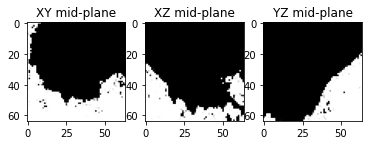

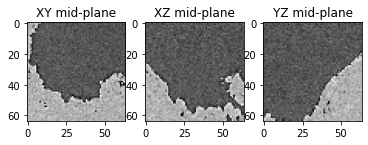

In [38]:
ii = 25
view_midplanes(vol = y_pred[ii])
view_midplanes(vol = x[ii])

In [39]:
y_pred[ii].mean()

0.34146827

In [40]:
fe.models["segmenter"].summary()

Model: "segmenter"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 64, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 64, 64, 3 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64, 3 128         conv3d[0][0]                     
__________________________________________________________________________________________

In [41]:
for ii in range(len(fe.models['segmenter'].layers)):
    lshape = str(fe.models['segmenter'].layers[ii].output_shape)
    lname = str(fe.models['segmenter'].layers[ii].name)
    print(lshape + "    ::    "  + lname) 

[(None, 64, 64, 64, 1)]    ::    input_1
(None, 64, 64, 64, 1)    ::    lambda
(None, 64, 64, 64, 32)    ::    conv3d
(None, 64, 64, 64, 32)    ::    batch_normalization
(None, 64, 64, 64, 32)    ::    leaky_re_lu
(None, 64, 64, 64, 64)    ::    conv3d_1
(None, 64, 64, 64, 64)    ::    batch_normalization_1
(None, 64, 64, 64, 64)    ::    leaky_re_lu_1
(None, 32, 32, 32, 64)    ::    max_pooling3d
(None, 32, 32, 32, 64)    ::    conv3d_2
(None, 32, 32, 32, 64)    ::    batch_normalization_2
(None, 32, 32, 32, 64)    ::    leaky_re_lu_2
(None, 32, 32, 32, 128)    ::    conv3d_3
(None, 32, 32, 32, 128)    ::    batch_normalization_3
(None, 32, 32, 32, 128)    ::    leaky_re_lu_3
(None, 8, 8, 8, 128)    ::    max_pooling3d_1
(None, 8, 8, 8, 128)    ::    conv3d_4
(None, 8, 8, 8, 128)    ::    batch_normalization_4
(None, 8, 8, 8, 128)    ::    leaky_re_lu_4
(None, 8, 8, 8, 256)    ::    conv3d_5
(None, 8, 8, 8, 256)    ::    batch_normalization_5
(None, 8, 8, 8, 256)    ::    leaky_re_lu_